In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd

from scipy.io import wavfile as wav

import os
import numpy as np
from tqdm import tqdm


from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
filename='Dataset/combined/03-01-05-02-01-02-03.wav'

In [106]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 6EE3-5608

 Directory of C:\Users\ShoaibSivany\emotiondetection\Audio-Classification-main

11/21/2021  11:36 AM    <DIR>          .
11/21/2021  11:36 AM    <DIR>          ..
11/21/2021  07:51 AM    <DIR>          .ipynb_checkpoints
11/17/2021  02:59 PM           438,305 Audio Classification EDA.ipynb
11/21/2021  10:29 AM    <DIR>          Dataset
04/02/2021  11:40 AM            35,149 LICENSE
11/21/2021  08:20 AM           110,545 Part 2- Audio Classification Data Preprocessing And Model Creation.ipynb
11/21/2021  07:49 AM           146,493 Part 2- Audio Classification Data Preprocessing.ipynb
04/02/2021  11:40 AM                22 README.md
11/21/2021  08:04 AM    <DIR>          saved_models
11/21/2021  08:20 AM    <DIR>          ss
11/21/2021  11:36 AM           558,032 Untitled.ipynb
11/21/2021  07:51 AM                 0 untitled.txt
               7 File(s)      1,288,546 bytes
               6 Dir(s)   4,703,858,688 bytes 

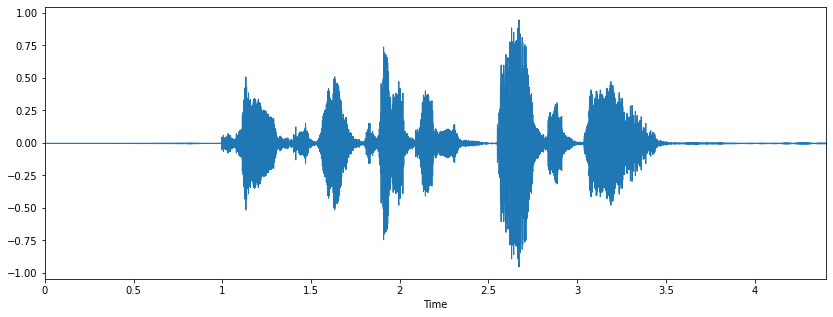

In [107]:
### Testing the audio as a sample
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

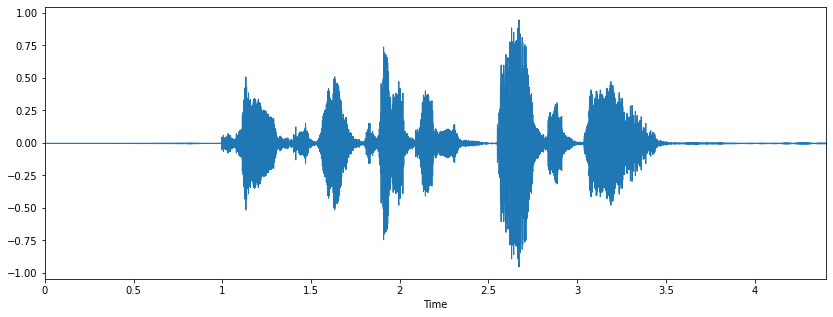

In [108]:
### Testing audio as a sample
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [109]:
sample_rate

22050

In [110]:

wave_sample_rate, wave_audio=wav.read(filename)



In [111]:
print(wave_sample_rate)
print(wave_audio)
print(data)

16000
[ 21   9  -2 ... -56 -61 -59]
[ 6.2559621e-04  4.6683938e-04  4.0069997e-05 ... -1.8797936e-03
 -2.0266266e-03  0.0000000e+00]


#### Audio Classification Data Preprocessing

In [145]:
###librosa sample audio reading
audio_path='Dataset/combined/03-01-05-02-01-02-03.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_path)

In [146]:
print(librosa_audio_data)

[ 6.2559621e-04  4.6683938e-04  4.0069997e-05 ... -1.8797936e-03
 -2.0266266e-03  0.0000000e+00]


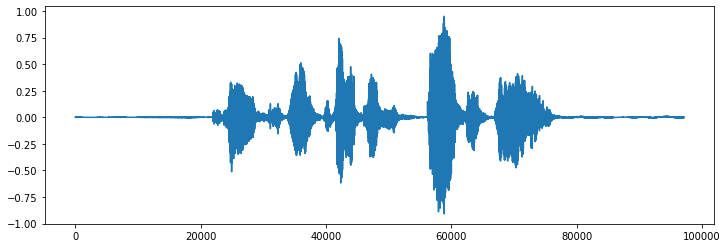

In [114]:

plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation
Here Librosa converts the signal to mono, meaning the channel will alays be 1

In [115]:

voice_sample_rate, voice_audio = wav.read(audio_path) 

In [116]:
voice_audio

array([ 21,   9,  -2, ..., -56, -61, -59], dtype=int16)

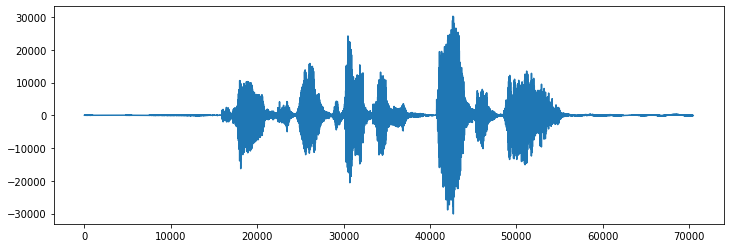

In [117]:
# 2 channels with original audio
plt.figure(figsize=(12, 4))
plt.plot(voice_audio)

### Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio 
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [118]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs)
print(mfccs.shape)

[[-5.29183167e+02 -5.27762390e+02 -5.30481445e+02 ... -5.21493042e+02
  -5.24119934e+02 -5.26328430e+02]
 [ 9.89347458e+00  9.73998642e+00  6.54473495e+00 ...  1.50901108e+01
   1.09748125e+01  1.18104820e+01]
 [ 1.76719213e+00 -8.90433192e-01 -3.54305410e+00 ...  5.23054600e+00
   2.59694600e+00  6.27938938e+00]
 ...
 [-4.89517152e-02  1.34558821e+00 -5.10120213e-01 ... -5.88528037e-01
   1.26443374e+00  2.08088660e+00]
 [ 5.58273733e-01  2.35066032e+00  2.65683246e+00 ...  2.72623777e+00
   3.84490132e+00  4.72274113e+00]
 [ 5.73068142e-01  1.61051834e+00  3.45088077e+00 ...  1.63397241e+00
   2.29309726e+00  2.40733147e+00]]
(40, 190)


In [119]:
audio_dataset_path='Dataset/combined'
metadata=pd.read_csv('Dataset/metadata2.csv')
metadata.head()

,slice_file_name,class
0,03-01-01-01-01-01-01.wav,1
1,03-01-01-01-01-02-01.wav,1
2,03-01-01-01-02-01-01.wav,1
3,03-01-01-01-02-02-01.wav,1
4,03-01-02-01-01-01-01.wav,1


In [120]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
    

In [121]:

### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1500it [02:03, 12.18it/s]


In [122]:
### converting extracted_features to the dataframe of pandas 
extracted_features_datafeatures=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_datafeatures.head()

,feature,class
0,"[-707.2263, 68.46979, -11.6113205, 22.716902, ...",1
1,"[-703.38324, 70.19777, -15.213276, 27.41265, -...",1
2,"[-700.794, 70.959595, -11.694939, 23.595743, -...",1
3,"[-694.82605, 69.669205, -9.815083, 23.888597, ...",1
4,"[-737.438, 77.27321, -11.19039, 26.755884, -1....",1


In [123]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_datafeatures['feature'].tolist())
y=np.array(extracted_features_datafeatures['class'].tolist())

In [124]:
print(X.shape)
print(y.shape)
print(X)
print(y)

(1500, 40)
(1500,)
[[-7.07226318e+02  6.84697876e+01 -1.16113205e+01 ... -2.19066167e+00
  -2.97666931e+00 -2.08753133e+00]
 [-7.03383240e+02  7.01977692e+01 -1.52132759e+01 ... -3.16274309e+00
  -2.94081926e+00 -2.60930109e+00]
 [-7.00794006e+02  7.09595947e+01 -1.16949387e+01 ... -2.67740035e+00
  -3.44238901e+00 -2.39960027e+00]
 ...
 [-5.58694763e+02  5.35197372e+01 -3.98429794e+01 ... -4.75117713e-01
  -9.07399178e-01 -1.48721427e-01]
 [-5.13990234e+02  5.32401962e+01 -3.29215088e+01 ...  4.27657694e-01
  -9.95232344e-01  9.83779728e-01]
 [-5.37082825e+02  5.58435822e+01 -2.79159031e+01 ... -4.94057029e-01
  -1.46590889e+00  3.27739924e-01]]
[1 1 1 ... 5 5 5]


In [144]:
y = np.array(pd.get_dummies(y));

Exception: Data must be 1-dimensional

In [126]:
y.shape

(1500, 6)

In [127]:
### Split Training Test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [128]:
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[-7.0771484e+02  7.4812363e+01 -1.0228953e+00 ... -6.4497823e-01
  -2.6108758e+00 -7.2262722e-01]
 [-5.9092029e+02  6.9091034e+01 -1.8998936e+01 ...  6.3119507e-01
   8.7872255e-01  1.6384201e+00]
 [-4.5696854e+02  4.1189415e+01 -6.5613419e+01 ...  1.4895804e+00
   4.0537510e+00  3.5897655e+00]
 ...
 [-4.8933746e+02  6.8746346e+01 -2.9062601e+01 ... -1.6758808e+00
  -1.3079224e+00 -1.6324504e-01]
 [-3.7202316e+02  4.5459175e+01 -4.8178139e+01 ...  7.6144701e-01
  -9.2661357e-01  7.0856172e-01]
 [-5.3828546e+02  6.2139561e+01 -3.2219650e+01 ...  1.2570375e+00
   1.4111817e+00  2.9829347e+00]]
[[0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]]
[[-6.4022913e+02  6.4260231e+01 -3.8410406e+00 ...  3.5444543e+00
   3.5128114e+00  3.9310384e+00]
 [-7.0988873e+02  8.3872131e+01 -1.6015291e+01 ... -2.9331839e+00
  -3.7964096e+00 -4.1001773e+00]
 [-5.3708282e+02  5.5843582e+01 -2.7915903e+01 ... -4.9405703e-01
  -1.4659089e+00  3.2773992e-01]
 ...
 [

### Model Creation

In [129]:
print(tf.__version__)

2.7.0


In [130]:
### Total classes
Total_labels=y.shape[1]

In [131]:
Total_labels

6

In [132]:
model=Sequential()
###first layer
model.add(Dense(200,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###third layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.1))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [133]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               8200      
                                                                 
 activation_8 (Activation)   (None, 200)               0         
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 activation_9 (Activation)   (None, 200)               0         
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 200)              

In [134]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [135]:
## Model Training


Total_epochs = 100
Total_batch_size = 8

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification3.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=Total_batch_size, epochs=Total_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
148/150 [============================>.] - ETA: 0s - loss: 7.1233 - accuracy: 0.2280
Epoch 00001: val_loss improved from inf to 1.78084, saving model to saved_models\audio_classification3.hdf5
150/150 [==============================] - 2s 9ms/step - loss: 7.0624 - accuracy: 0.2267 - val_loss: 1.7808 - val_accuracy: 0.1700
Epoch 2/100
143/150 [===========================>..] - ETA: 0s - loss: 2.3121 - accuracy: 0.2666
Epoch 00002: val_loss improved from 1.78084 to 1.52524, saving model to saved_models\audio_classification3.hdf5
150/150 [==============================] - 1s 8ms/step - loss: 2.2964 - accuracy: 0.2675 - val_loss: 1.5252 - val_accuracy: 0.4300
Epoch 3/100
143/150 [===========================>..] - ETA: 0s - loss: 1.8529 - accuracy: 0.3138

KeyboardInterrupt: 

In [136]:
rate_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(rate_accuracy[1])

0.4466666579246521


In [137]:
X_test[1]

array([-7.0988873e+02,  8.3872131e+01, -1.6015291e+01,  2.4925694e+01,
       -3.6760423e+00,  7.7347674e+00, -8.8709545e+00, -4.6435766e+00,
       -7.4369583e+00, -6.9562426e+00,  5.1160092e+00, -4.1781750e+00,
        9.2252713e-01, -6.0807533e+00,  3.2918021e-01, -7.9200852e-01,
       -4.7846680e+00, -1.4422736e+00, -1.6075087e+00,  1.5010141e-01,
       -6.5366683e+00, -3.3961073e-01, -1.4284160e+00, -4.9214768e+00,
       -9.6341735e-01, -3.2747202e+00, -2.8020306e+00, -1.6667454e+00,
       -1.1398808e+00, -2.1091456e+00, -2.7733836e+00, -3.5254228e+00,
       -3.3421659e+00, -3.6882679e+00, -4.5428481e+00, -1.8130788e+00,
       -1.5003438e+00, -2.9331839e+00, -3.7964096e+00, -4.1001773e+00],
      dtype=float32)

In [138]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [139]:
classes_x

array([0, 0, 5, 0, 5, 5, 0, 0, 0, 5, 0, 5, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0,
       0, 0, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 0, 5, 0, 5, 5, 5, 0, 0, 5, 0,
       0, 0, 0, 5, 0, 0, 5, 5, 5, 5, 0, 5, 0, 0, 5, 0, 0, 0, 5, 5, 0, 5,
       5, 0, 5, 0, 5, 0, 5, 5, 0, 5, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 0,
       0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 5, 0,
       0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0,
       5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 5, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 5, 5, 5, 5, 0, 0,
       0, 0, 0, 5, 0, 5, 0, 5, 5, 5, 0, 0, 5, 0, 0, 5, 5, 0, 0, 0, 0, 0,
       0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 5, 5, 0, 0,
       0, 0, 0, 5, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 5, 5, 0, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 5, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0], d

### Testing Some Test Actor Data

Steps
- Preprocess the new audio data
- predict the classes

In [142]:
filename="Dataset/Actor_09/03-01-06-02-02-02-09.wav"
voice, rate_sample = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=voice, sr=rate_sample, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

predict_x=model.predict(mfccs_scaled_features) 
classes_x=np.argmax(predict_x,axis=1)

print(classes_x)

[-5.3765796e+02  7.1580582e+01 -1.3974549e+01  2.2829094e+01
  3.3867757e+00  1.0070583e+00 -1.0889779e+01 -1.1702728e+00
 -9.5458632e+00 -5.9591827e+00  1.9629906e+00 -1.4733294e+01
 -2.2801013e+00  9.3267900e-01 -1.7262820e+00  9.2644739e-01
  3.1538863e+00 -6.9151883e+00 -3.1043389e+00  5.7416706e+00
 -4.7557535e+00 -3.7945852e+00 -6.0351472e+00 -3.2026744e+00
 -1.5435342e+00 -5.0797729e+00 -4.5797019e+00 -3.0592124e+00
  6.2447220e-01 -3.3166084e+00  5.2384955e-01  2.6901715e+00
  1.0976957e+00  3.0890708e+00  2.1418810e+00  3.9266968e+00
  2.4705007e+00  1.1723317e+00  3.1649587e+00  4.4961915e+00]
[[-5.3765796e+02  7.1580582e+01 -1.3974549e+01  2.2829094e+01
   3.3867757e+00  1.0070583e+00 -1.0889779e+01 -1.1702728e+00
  -9.5458632e+00 -5.9591827e+00  1.9629906e+00 -1.4733294e+01
  -2.2801013e+00  9.3267900e-01 -1.7262820e+00  9.2644739e-01
   3.1538863e+00 -6.9151883e+00 -3.1043389e+00  5.7416706e+00
  -4.7557535e+00 -3.7945852e+00 -6.0351472e+00 -3.2026744e+00
  -1.5435342e+00 

In [143]:
predict_x=model.predict(X_test[0]) 
classes_x=np.argmax(predict_x,axis=1)

ValueError: in user code:

    File "c:\users\shoaibsivany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\shoaibsivany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\shoaibsivany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\shoaibsivany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "c:\users\shoaibsivany\appdata\local\programs\python\python37\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\shoaibsivany\appdata\local\programs\python\python37\lib\site-packages\keras\engine\input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "dense_8" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [1]:
import tflite_runtime.interpreter as tflite


In [5]:
interpreter = tflite.Interpreter(model_path='saved_models/audio_classification3.hdf5')


ValueError: Model provided has model identifier '

', should be 'TFL3'


In [1]:
import tensorflow as tf

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_models') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

OSError: SavedModel file does not exist at: saved_models\{saved_model.pbtxt|saved_model.pb}

In [5]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'saved_models/audio_classification.hdf5')
tfmodel = converter.convert()
open ("model.tflite" , "wb").write(tfmodel)

ModuleNotFoundError: No module named 'tensorflow.contrib'